In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import random
from models import *

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# general parameters
dataset_name = "BA_Community"

model_type = BA_Community_GCN
load_pretrained = False

# hyperparameters
k = 20

# other parameters
train_test_split = 0.8
num_hidden_units = 30
num_classes = 8

epochs = 7000
lr = 0.001

Task: Node Classification
Number of features:  871
Number of labels:  871
Number of edges:  871


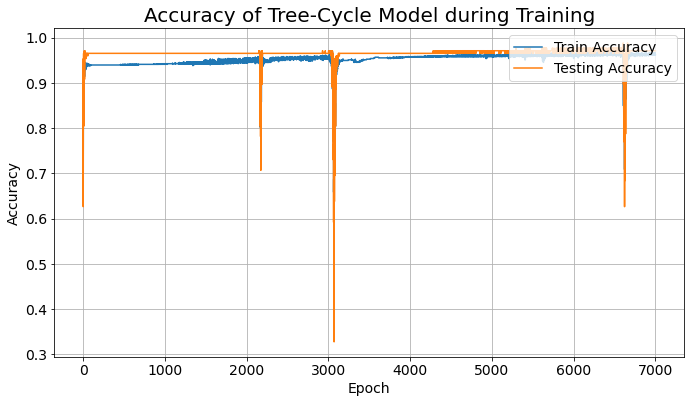

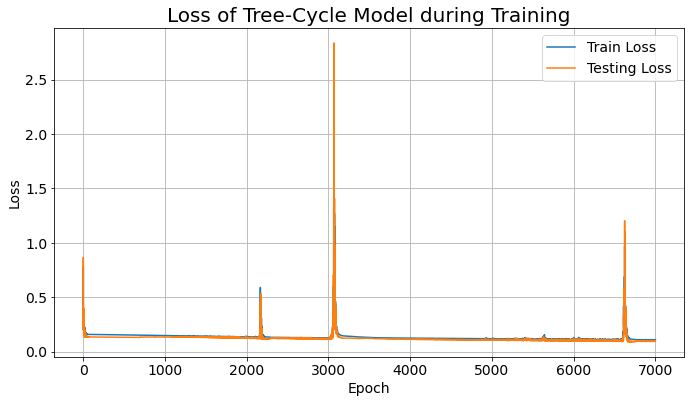

In [14]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split, if_adj=True)
model = model_type(data["x"].shape[1], num_hidden_units, num_classes)

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, 7000, lr, paths['base'])

In [15]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
print(test(model, x, y, edges, test_mask))
print(test(model, x, y, edges, train_mask))

0.9712643678160919
0.9626972740315638


In [21]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)
    
print(paths['base'])
print(paths['DBSCAN'])
os.getcwd()


torch.save(model.state_dict(), "tree_cycle_model.pkl")

with open("tree_cycle_activations.txt", 'wb') as file:
    pickle.dump(activation_list, file)

(871, 50)
(871, 50)
(871, 50)
output/Tree_Cycle/
output/Tree_Cycle/DBSCAN


# Dimensionality Reduction

### TSNE

In [6]:
# TSNE conversion
tsne_models = []
tsne_data = []

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

KeyboardInterrupt: 

### PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

In [ ]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [ ]:
num_nodes_view = 5
num_expansions = 2
edges = data['edge_list'].numpy()

raw_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_sample_graphs.append(sample_graphs)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [ ]:
tsne_sample_graphs = []
tsne_sample_feat = []
tsne_kmeans_models = []
for layer_num, item in enumerate(tsne_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [ ]:
pca_sample_graphs = []
pca_sample_feat = []
pca_kmeans_models = []

for layer_num, item in enumerate(pca_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

##### UMAP

In [ ]:
umap_sample_graphs = []
umap_sample_feat = []
umap_kmeans_models = []
for layer_num, item in enumerate(umap_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    umap_sample_graphs.append(sample_graphs)
    umap_sample_feat.append(sample_feat)
    umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [ ]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [ ]:
raw_n_clusters = [3, 3, 12, 13]

raw_sample_graphs = []
raw_sample_feat = []
raw_ward_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(activation)

    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_ward_models.append(hc)


##### TSNE

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [ ]:
tsne_n_clusters = [7, 12, 12, 13]

tsne_sample_graphs = []
tsne_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)


##### PCA

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [ ]:
pca_n_clusters = [7, 12, 12, 13]

pca_sample_graphs = []
pca_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

##### UMAP

In [ ]:
for layer_num, item in enumerate(umap_data):
    plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [ ]:
umap_n_clusters = [7, 12, 12, 13]

umap_sample_graphs = []
umap_sample_feat = []
umap_hc_models = []
for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    umap_sample_graphs.append(sample_graphs)
    umap_sample_feat.append(sample_feat)
    umap_hc_models.append(hc)

#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [ ]:
num_nodes_view = 5
num_expansions = 3
edges = data['edge_list'].numpy()

esp = 0.1
min_samples = 6

raw_sample_graphs = []
raw_dbscan_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(activation)
    pred_labels = dbscan_model.fit_predict(activation)

    num_cluster = len(np.unique(pred_labels))
    d = (activation, pred_labels)

    plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    raw_sample_graphs.append(sample_graphs)
    raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [ ]:
tsne_sample_graphs = []
tsne_dbscan_models = []
for layer_num, item in enumerate(tsne_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    tsne_sample_graphs.append(sample_graphs)
    tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [ ]:
pca_sample_graphs = []
pca_dbscan_models = []
for layer_num, item in enumerate(pca_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    pca_sample_graphs.append(sample_graphs)
    pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [ ]:
umap_sample_graphs = []
umap_dbscan_models = []
for layer_num, item in enumerate(umap_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    umap_sample_graphs.append(sample_graphs)
    umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)

    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)

    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "PCA")

for i, item in enumerate(umap_data):
    activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)

    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [ ]:
# # check training progress

# x = data["x"]
# edges = data["edges"]
# y = data["y"]
# train_mask = data["train_mask"]
# test_mask = data["test_mask"]
# print(test(model, x, y, edges, test_mask))

# activation = torch.squeeze(activation_list['conv2']).detach().numpy()
# kmeans_model = KMeans(n_clusters=9, random_state=0)
# kmeans_model = kmeans_model.fit(activation)

# testing = ActivationClassifier(activation, kmeans_model, classifier_str, data["x"], data["y"], data["x"], data["y"], data["edges"], i)
# print(testing.accuracy)


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
# for i, item in enumerate(umap_data):
#     activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
# plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "raw")
    
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "UMAP")

plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     activation_cls = ActivationClassifier(activation, raw_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     activation_cls = ActivationClassifier(item, tsne_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     activation_cls = ActivationClassifier(item, pca_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     activation_cls = ActivationClassifier(item, umap_ward_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["Ward"], i, n, "UMAP")

# plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    
    dbscan_model, n = raw_dbscan_models[i]
    activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    dbscan_model, n = tsne_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, item in enumerate(umap_data):
    dbscan_model, n = umap_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [ ]:
# classifier_str = "logistic_regression"

# completeness_scores = []

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     dbscan_model, n = raw_dbscan_models[i]
#     activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
# for i, item in enumerate(tsne_data):
#     dbscan_model, n = tsne_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     dbscan_model, n = umap_dbscan_models[i]
#     activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"], data["edge_list"], i)
    
#     d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
#     completeness_scores.append(d)
#     activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

# plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [ ]:
##### KMeans

In [ ]:
# graph_scores = []
# view = 3
# max_num_nodes = 15

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     distances = get_node_distances(raw_kmeans_models[i], activation)

#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["KMeans", "Raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_kmeans_models[i], activation, i, k, "KMeans-Raw", view, edges, num_expansions, paths['KMeans'])
        
# for i, item in enumerate(tsne_data):    
#     distances = get_node_distances(tsne_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["KMeans", "TSNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_kmeans_models[i], item, i, k, "KMeans-TSNE", view, edges, num_expansions, paths['KMeans'])
    
# for i, item in enumerate(pca_data):
#     distances = get_node_distances(pca_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["KMeans", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_kmeans_models[i], item, i, k, "KMeans-PCA", view, edges, num_expansions, paths['KMeans'])


# for i, item in enumerate(umap_data):
#     distances = get_node_distances(umap_kmeans_models[i], item)
    
#     for k_idx in range(k):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["KMeans", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_kmeans_models[i], item, i, k, "KMeans-UMAP", view, edges, num_expansions, paths['KMeans'])
    
# plot_graph_similarity_table("Kmeans", graph_scores, paths['KMeans'])
    

In [ ]:
# graph_scores = []
# view = 3
# max_nodes = 15

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     pred_labels = raw_hc_models[i].fit_predict(activation)
#     d_item = (activation, pred_labels)
#     distances = get_node_distances(raw_hc_models[i], d_item)
    
#     for k_idx in range(n):        
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
                
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["HC", "Raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC-Raw", view, edges, num_expansions, paths['HC'])
        
        
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
#     pred_labels = tsne_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(tsne_hc_models[i], d_item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["HC", "TSNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC-TSNE", view, edges, num_expansions, paths['HC'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["HC", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC-PCA", view, edges, num_expansions, paths['HC'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_hc_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_hc_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC-UMAP", view, edges, num_expansions, paths['HC'])
        
    
# plot_graph_similarity_table("HC", graph_scores, paths['HC'])
    

In [ ]:
# graph_scores = []
# view = 3
# max_nodes = 15

# for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
#     pred_labels = raw_ward_models[i].fit_predict(activation)
#     d_item = (activation, pred_labels)
#     distances = get_node_distances(raw_ward_models[i], d_item)
    
#     for k_idx in range(n):        
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
                
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["HC", "Raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(raw_ward_models[i], d_item, data["y"], i, n, "Ward-Raw", view, edges, num_expansions, paths['Ward'])
        
        
# for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
#     pred_labels = tsne_ward_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(tsne_ward_models[i], d_item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["Ward", "TSNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(tsne_ward_models[i], d_item, data["y"], i, n, "Ward-TSNE", view, edges, num_expansions, paths['Ward'])
        

        
# for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
#     pred_labels = pca_ward_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(pca_ward_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["Ward", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(pca_ward_models[i], d_item, data["y"], i, n, "Ward-PCA", view, edges, num_expansions, paths['Ward'])
    

# for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
#     pred_labels = umap_ward_models[i].fit_predict(item)
#     d_item = (item, pred_labels)
#     distances = get_node_distances(umap_ward_models[i], d_item)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[k_idx])[::][:view]
#         top_graphs, _, _ = get_top_subgraphs(top_indices, data["y"], edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, max_nodes, view)
#         print(score)
        
#         d = ["Ward", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(umap_ward_models[i], d_item, data["y"], i, n, "Ward-UMAP", view, edges, num_expansions, paths['Ward'])
        
    
# plot_graph_similarity_table("Ward", graph_scores, paths['Ward'])
    

In [ ]:
# graph_scores = []
# view = 3

# for i, key in enumerate(activation_list):
#     activation = torch.squeeze(activation_list[key]).detach().numpy()
    
#     dbscan_model, n = raw_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, activation)

#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["DBSCAN", "Raw", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, activation, i, k, "DBSCAN-Raw", view, edges, num_expansions, paths['DBSCAN'])
        
# for i, item in enumerate(tsne_data):  
#     dbscan_model, n = tsne_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)

#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["DBSCAN", "TSNE", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, item, i, k, "DBSCAN-TSNE", view, edges, num_expansions, paths['DBSCAN'])
    
# for i, item in enumerate(pca_data):
#     dbscan_model, n = pca_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, item, i, k, "DBSCAN-PCA", view, edges, num_expansions, paths['DBSCAN'])


# for i, item in enumerate(umap_data):
#     dbscan_model, n = umap_dbscan_models[i]
#     distances = get_node_distances(dbscan_model, item)
    
#     for k_idx in range(n):
#         top_indices = np.argsort(distances[:, k_idx])[::][:view]
#         top_graphs, _ = get_top_subgraphs(top_indices, edges, num_expansions)
        
#         score = calc_graph_similarity(top_graphs, view)
#         print(score)
        
#         d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
#         graph_scores.append(d)
        
#     plot_samples(dbscan_model, item, i, k, "DBSCAN-UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
# plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
# node_idx = 572

# # convert to edge format
# edges = edge_list.transpose(0, 1).t().contiguous()

# explainer = GNNExplainer2(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, node_data_x, edges)

In [ ]:
# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=node_data_y, threshold=0.8)
# plt.show()